In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
#Just to have each print in the same row
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [3]:
r'''   
trusted_data_w_ocupacion: *trusted_data* with actual ocupacion included.
    path: r'C:\Users\ing_l\Tesis grado\Data\BD_parking_trusted_data_ocupacion.csv'
    
data_w_operacion: (DataFrame) data with the corresponding operacion (Entrada/Salida).
    path: C:\Users\ing_l\Tesis grado\Data\SUMO_data_w_operacion.csv

'''

trusted_data_path_w_ocupacion = r'C:\Users\ing_l\Tesis grado\Data\BD_parking_trusted_data_ocupacion.csv'
data_w_operacion_path = r'C:\Users\ing_l\Tesis grado\Data\SUMO_data_w_operacion.csv'

# TODAVIA TENGO QUE SACAR LOS NaN DE SUMO_data

In [4]:
SUMO_data = pd.read_csv(data_w_operacion_path)
SUMO_data.rename(columns={'fecha_tiempo': 'fecha_hora'}, inplace=True)
BD_parking_data = pd.read_csv(trusted_data_path_w_ocupacion)

## Cuadras donde más se estaciona (SUMO)

In [5]:
max_ocupacion = SUMO_data.copy()
max_ocupacion = max_ocupacion[['id_cuadra','ocupacion_max', 'lugares_cuadra']].groupby(by='id_cuadra').max().reset_index()
max_ocupacion = max_ocupacion.sort_values(by='ocupacion_max')
max_ocupacion

,id_cuadra,ocupacion_max,lugares_cuadra
89,92,1,NaN
91,94,4,NaN
90,93,4,NaN
96,99,5,NaN
75,78,5,14.0
...,...,...,...
30,33,23,32.0
72,75,23,31.0
29,32,27,27.0
12,14,27,30.0


### Para esto todavia faltaria tener mas datos y poder deducir algo del maximo valor posible. Por ahora ningun dato tiene sentido y por la poca cantidad tampoco puedo deducir mucho.

## Cuadras de mas y menos transito

In [6]:
traffic = SUMO_data.copy()
traffic = traffic[['id_cuadra','direccion']].groupby(by='id_cuadra').count().reset_index()
traffic = traffic.sort_values(by='direccion')
traffic.rename(columns={'direccion': 'count'}, inplace=True)
max_traffic = traffic.tail(10).reset_index(drop=True)
min_traffic = traffic.head(10).reset_index(drop=True)

display(min_traffic)
display(max_traffic)

,id_cuadra,count
0,92,7
1,93,82
2,95,118
3,94,123
4,50,131
5,85,143
6,77,153
7,71,161
8,78,181
9,79,217


,id_cuadra,count
0,10,1031
1,22,1043
2,33,1057
3,5,1079
4,46,1091
5,45,1154
6,4,1173
7,6,1219
8,11,1280
9,59,1331


## To plot graphs

In [7]:
def get_filtered_time(plot_data, k=5):
    '''
    Obtains a dataframe with fixed dates to plot
    
    Parameters: 
        plot_data_date: dataframe containing the fecha_hora values of the plotted data
        k: how much dates will appear in the graph
        
    Returns: a dataframe containing only k dates and empty values
    '''
    
    #Get the timestamp of the fecha_hora column
    time = plot_data['fecha_hora'].reset_index(drop=True).apply(lambda x: pd.Timestamp(x)).copy()
    
    #Obtain the nearest row to 13:00hs
    '''same_hour = time.apply(lambda x: x.hour == 13)
    same_minutes = time.apply(lambda x: x.minute < 10)
    same_time = same_hour * same_minutes
    same_time_index = time[same_time].index[0]
    '''
    #Get the k values to be appended in the out (time var)
    size = len(time)
    pos = [0]
    vals = [str(time[pos[0]].time())]
    for i in range(1,k+1):
        pos.append(int(size*(i/k)) - 1)
        vals.append(str(time[pos[i]].time()))
    #pos[int(len(pos)/2)+1] = same_time_index
    #vals[int(len(vals)/2)+1] = str(time[pos[int(len(vals)/2)+1]].time())
    '''pos = [0, int(size*(1/4)), same_time_index, int(size*(3/4)), int(size-1)]
    val1 = str(time[pos[0]].time())
    val2 = str(time[pos[1]].time())
    val3 = str(time[pos[2]].time())
    val4 = str(time[pos[3]].time())
    val5 = str(time[pos[4]].time())
    '''
    #Fill with empty values the time Series
    time = pd.Series('', index=time.index)
    
    #Put all obtained values into time Series
    for i in range(k+1):
        time.iloc[pos[i]] = vals[i]
    '''time.iloc[pos[0]] = val1
    time.iloc[pos[1]] = val2
    time.iloc[pos[2]] = val3
    time.iloc[pos[3]] = val4
    time.iloc[pos[4]] = val5
    '''
    return time

In [8]:
def plot_line_graph(plot_data, date, max_ocup=30, name='Original', color='b', k=5):
    global street

    #Get the values for each date we have
    plot_data_date = plot_data.loc[plot_data.fecha == pd.Timestamp(date).date()].copy()

    #Obtaining the mean to plot in the title of the graph
    mean = plot_data_date['ocupacion'].mean()
    #Modify the plot size
    plt.rcParams['figure.figsize'] = (12,4)
    
    #The max value
    plt.ylim([0, max_ocup+1])

    #Just for the x axis, get the first, medium and last time value
    time = get_filtered_time(plot_data_date, k)
                
    #Set the label titles
    plt.xlabel('Time')
    plt.ylabel('Parked cars')
    plt.title('Parked cars in street nº{} along the day. Mean parked cars: {}'.format(street, mean))
    
    #Set the plot data for each graph (ax1,ax2,ax3)
    plt.plot(plot_data_date['fecha_hora'], plot_data_date['ocupacion'], label='{} date'.format(name), color=color)
    
    plt.xticks(plot_data_date['fecha_hora'], time)
    plt.legend()
    plt.show()

## BD parking


In [9]:
to_plot_data = BD_parking_data.copy()

street = 2
date = '2018-01-02' 

## SUMO

In [10]:
to_plot_data = SUMO_data.copy()

street = 2
date = '2019-09-13'

In [11]:
to_plot_data

,fecha_hora,id_cuadra,direccion,ocupacion,lugares_cuadra,ocupacion_max,dispon_parq,altas_bajas(dia),operacion
0,2019-09-13 07:48:01,2,General Pinto 545,1,27.0,1,green,1,NaN
1,2019-09-13 08:48:04,2,General Pinto 545,2,27.0,2,green,4,Entrada
2,2019-09-13 08:51:43,2,General Pinto 545,1,27.0,2,green,5,Salida
3,2019-09-13 09:25:06,2,General Pinto 545,2,27.0,2,green,6,Entrada
4,2019-09-13 09:39:36,2,General Pinto 545,3,27.0,3,green,7,Entrada
...,...,...,...,...,...,...,...,...,...
62439,2019-09-24 11:25:17,99,Av. España 970,4,NaN,4,green,23,Entrada
62440,2019-09-24 11:30:39,99,Av. España 970,3,NaN,4,green,23,Salida
62441,2019-09-24 11:40:39,99,Av. España 970,2,NaN,4,green,28,Salida
62442,2019-09-24 11:42:42,99,Av. España 970,3,NaN,4,green,28,Entrada


### Call only one above and the one below

In [12]:
from datetime import datetime 
import matplotlib.pyplot as plt

street_name = to_plot_data.loc[to_plot_data.id_cuadra == street, 'direccion'].iloc[0]

plot_data = to_plot_data.loc[to_plot_data.id_cuadra == street, ['fecha_hora','ocupacion']].copy()

plot_data['fecha'] = plot_data['fecha_hora'].apply(lambda x: pd.Timestamp(x).date())

#Date of the max transited day in selected street
max_mean = plot_data.groupby(by='fecha').mean().max()[0]
date_max_mean = plot_data.groupby(by='fecha').mean().reset_index()
date_max_mean = date_max_mean.loc[date_max_mean['ocupacion'] == max_mean, 'fecha'].iloc[0]



#############VER SI LA CAGUE O NO
def search_date_min_mean(p_d, min_quantity=150):
    '''
    To search the day with less parked cars, but with at least
    min_quantity registers (rows)
    '''
    plot_data = p_d.copy()
    
    min_mean = plot_data.groupby(by='fecha').mean()

    #If we've already looked at every row and we dont have anyone with more than 150 rows
    #we choose the nearest one
    if len(min_mean) == 0:
        return None
    
    #Look at the minumun, if it has more rows than the min_quantity return it, else 
    #continue searching
    min_mean = min_mean.min()[0]
    date_min_mean = plot_data.groupby(by='fecha').mean().reset_index()
    date_min_mean = date_min_mean.loc[date_min_mean['ocupacion'] == min_mean, 'fecha'].iloc[0]
    if len(plot_data.loc[plot_data['fecha'] == date_min_mean]) < min_quantity:
        plot_data = plot_data.loc[plot_data['fecha'] != date_min_mean]
        out = search_date_min_mean(plot_data)
        if out is not None:
            return out
        else:
            return date_min_mean
    else:
        return date_min_mean

#Date of the min transited day in selected street
date_min_mean = search_date_min_mean(plot_data)

print(street_name)

#Getting the max ocup to plot all the graphs with the same y-axis values
max_ocup1 = plot_data.loc[plot_data['fecha'] == pd.Timestamp(date).date(),'ocupacion'].max()
max_ocup2 = plot_data.loc[plot_data['fecha'] == pd.Timestamp(date_max_mean).date(), 'ocupacion'].max()
max_ocup3 = plot_data.loc[plot_data['fecha'] == pd.Timestamp(date_min_mean).date(), 'ocupacion'].max()
max_ocup = max(max_ocup1, max_ocup2, max_ocup3)

General Pinto 545


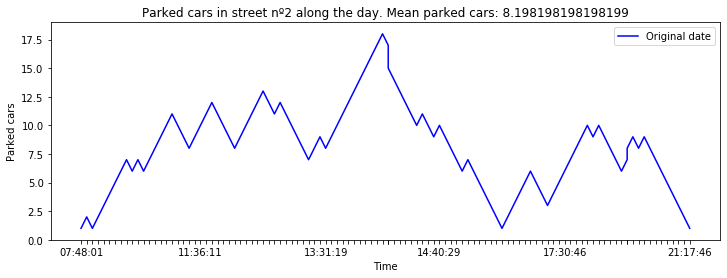

In [13]:
plot_line_graph(plot_data, date, max_ocup=max_ocup)

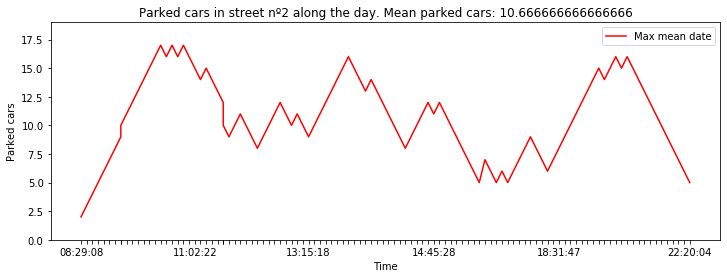

In [14]:
plot_line_graph(plot_data, date_max_mean, max_ocup=max_ocup, name='Max mean', color='r')

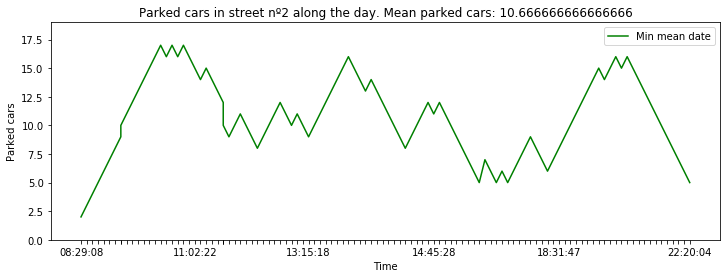

In [15]:
plot_line_graph(plot_data, date_min_mean, max_ocup=max_ocup, name='Min mean', color='g')

## En una ventana de tiempo (aprox al mediodia, donde mas se estacionen normalmente) la cantidad de entradas y salidas que se tienen para poder predecir donde se podrian liberar lugares para estacionar mas frecuentemente

In [19]:
#Create column dia and tiempo just to obtain the inputs and outputs in an easy way
in_out_per_hour= SUMO_data.copy()
in_out_per_hour = in_out_per_hour[['id_cuadra','fecha_hora','operacion']]
in_out_per_hour['dia'] = in_out_per_hour['fecha_hora'].apply(lambda x: pd.Timestamp(x).date().day)
in_out_per_hour['tiempo'] = in_out_per_hour['fecha_hora'].apply(lambda x: pd.Timestamp(x).time().hour)

#Obtain 2 df, one with the count of the inputs and the other with the count of the outputs
in_per_hour = in_out_per_hour.loc[in_out_per_hour['operacion'] == 'Entrada', ['dia','tiempo','id_cuadra', 'operacion']].groupby(by=['id_cuadra', 'dia','tiempo']).count()
out_per_hour = in_out_per_hour.loc[in_out_per_hour['operacion'] == 'Salida', ['dia','tiempo','id_cuadra', 'operacion']].groupby(by=['id_cuadra', 'dia','tiempo']).count()
in_per_hour.rename(columns={'operacion': 'entradas'}, inplace=True)
out_per_hour.rename(columns={'operacion': 'salidas'}, inplace=True)

#Useless
delete = in_per_hour.reset_index()
delete = delete.loc[(delete.id_cuadra == 59) & (delete.tiempo == 13)]

#Obtain the mean of the inputs and outputs
in_per_hour = in_per_hour.groupby(by=['id_cuadra','tiempo']).mean().reset_index()
out_per_hour = out_per_hour.groupby(by=['id_cuadra','tiempo']).mean().reset_index()

#Merge both in and out per hour to get the diff
in_out_per_hour = in_per_hour.merge(out_per_hour, how='outer', on=['id_cuadra','tiempo'])
in_out_per_hour.fillna(0, inplace=True)

#Subs values
in_out_per_hour['in - out'] = in_out_per_hour['entradas'] - in_out_per_hour['salidas']

In [20]:
#Useless
display(in_per_hour.loc[in_per_hour['id_cuadra'] == 2])
display(out_per_hour.loc[out_per_hour['id_cuadra'] == 2])

,id_cuadra,tiempo,entradas
0,2,7,1.000000
1,2,8,1.666667
2,2,9,5.333333
3,2,10,7.800000
4,2,11,4.777778
5,2,12,4.666667
6,2,13,7.625000
7,2,14,5.375000
8,2,15,3.333333
9,2,16,3.500000


,id_cuadra,tiempo,salidas
0,2,0,2.000000
1,2,8,1.000000
2,2,9,2.000000
3,2,10,3.500000
4,2,11,5.777778
5,2,12,4.666667
6,2,13,6.900000
7,2,14,5.777778
8,2,15,5.375000
9,2,16,2.444444


In [29]:
'''
in-out > 0: more entradas than salidas
in-out < 0: more salidas than entradas
'''
in_out_per_hour.rename(columns={'tiempo': 'hora'}, inplace=True)
display(in_out_per_hour)

,id_cuadra,hora,entradas,salidas,in - out
0,2,7,1.000000,0.000000,1.000000
1,2,8,1.666667,1.000000,0.666667
2,2,9,5.333333,2.000000,3.333333
3,2,10,7.800000,3.500000,4.300000
4,2,11,4.777778,5.777778,-1.000000
...,...,...,...,...,...
1519,98,20,0.000000,2.125000,-2.125000
1520,98,21,0.000000,1.750000,-1.750000
1521,98,23,0.000000,1.000000,-1.000000
1522,99,0,0.000000,1.333333,-1.333333


In [33]:
'''
in-out > 0: more entradas than salidas
in-out < 0: more salidas than entradas
'''
street = 59
print(to_plot_data.loc[to_plot_data.id_cuadra == street, 'direccion'].iloc[0])
in_out_per_hour.rename(columns={'tiempo': 'hora'}, inplace=True)

Yrigoyen 655


In [37]:
#First we display the in-out for the designated street orderer by the hora
display(in_out_per_hour.loc[in_out_per_hour['id_cuadra'] == street, ['hora','in - out']].reset_index(drop=True))

#And at the right we will display the in-out orderer by the in-out (ascendant)
display(in_out_per_hour.loc[in_out_per_hour['id_cuadra'] == street, ['hora','in - out']].sort_values(by='in - out').reset_index(drop=True))

,hora,in - out
0,7,1.800000
1,8,2.200000
2,9,4.200000
3,10,10.677778
4,11,-1.400000
5,12,-5.000000
6,13,-0.400000
7,14,-2.042857
8,15,0.125000
9,16,2.755556


,hora,in - out
0,20,-8.555556
1,19,-5.833333
2,12,-5.000000
3,21,-3.142857
4,0,-2.571429
5,14,-2.042857
6,22,-2.000000
7,23,-1.500000
8,11,-1.400000
9,13,-0.400000
